In [1]:
import pandas as pd
import numpy as np
import networkx as nx

##### Read airports data

In [2]:
airport_col = ['ID', 'Name', 'City', 'Country','IATA', 'ICAO', 'Lat', 'Long', 'Alt', 
               'Timezone', 'DST', 'Tz database time zone', 'type', 'source']
airport_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat",
                        names = airport_col, index_col = 0)

In [3]:
airport_df.shape

(7184, 13)

In [ ]:
airport_df.Country.unique()

In [20]:
airport_us = airport_df[(airport_df.Country == "United States")]

In [28]:
airport_us.shape

(1435, 13)

In [21]:
airport_us = airport_us[['Name','Lat', 'Long', 'IATA', 'ICAO']]

In [22]:
airport_us.head()

,Name,Lat,Long,IATA,ICAO
ID,,,,,
3411,Barter Island LRRS Airport,70.134003,-143.582001,BTI,PABA
3413,Cape Lisburne LRRS Airport,68.875099,-166.110001,LUR,PALU
3414,Point Lay LRRS Airport,69.732903,-163.005005,PIZ,PPIZ
3415,Hilo International Airport,19.721399,-155.048004,ITO,PHTO
3416,Orlando Executive Airport,28.545500,-81.332901,ORL,KORL


##### Read routes data

In [7]:
route_name = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                        names = route_name)

In [8]:
routes_df.dtypes

Airline              object
Airline ID           object
Source Airport       object
Source Airport ID    object
Dest Airport         object
Dest Airport ID      object
Codeshare            object
Stops                 int64
equipment            object
dtype: object

In [9]:
routes_df.shape

(67663, 9)

In [10]:
# get index array of airport_us
us_airport_ix = airport_us.index.values
us_airport_ix

array([ 3411,  3413,  3414, ..., 11868, 11918, 11919], dtype=int64)

In [13]:
len(us_airport_ix)

1435

In [11]:
routes_df['Source Airport ID'] = routes_df['Source Airport ID'].astype(str)
routes_df['Dest Airport ID'] = routes_df['Dest Airport ID'].astype(str)
routes_df = routes_df[(routes_df['Source Airport ID'] != "\N") & (routes_df['Dest Airport ID'] != "\N") ]

In [12]:
routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'])
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'])

In [16]:
routes_df.dtypes

Airline              object
Airline ID           object
Source Airport       object
Source Airport ID     int64
Dest Airport         object
Dest Airport ID       int64
Codeshare            object
Stops                 int64
equipment            object
dtype: object

In [13]:
routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
                     (routes_df['Dest Airport ID'].isin(us_airport_ix))]

In [14]:
routes_us= routes_us[['Source Airport', 'Source Airport ID', 'Dest Airport', 'Dest Airport ID', 'Airline']]

In [15]:
routes_us.head()

,Source Airport,Source Airport ID,Dest Airport,Dest Airport ID,Airline
172,ADQ,3531,KLN,7162,2O
177,KLN,7162,KYK,7161,2O
260,BRL,5726,ORD,3830,3E
261,BRL,5726,STL,3678,3E
262,DEC,4042,ORD,3830,3E


In [16]:
routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))

In [22]:
len(routes_us['Source Airport'].unique())

540

In [23]:
len(routes_us['Dest Airport'].unique())

538

In [18]:
# to find number of flights in and out of an airport
# it is similar to find number of rows in which each airport occur in either one of the 2 columns

#You can use loc to filter out row level matches from 'col2', 
#append the filtered 'col2' values to 'col1',
#and then call value_counts

counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()

In [19]:
counts.index

Index([u'ATL', u'ORD', u'DEN', u'DFW', u'MSP', u'DTW', u'LAS', u'CLT', u'IAH',
       u'PHL',
       ...
       u'TLJ', u'MLY', u'IGG', u'PTH', u'KPV', u'PTU', u'PIP', u'LUR', u'SLQ',
       u'AGN'],
      dtype='object', length=546)

In [20]:
# create a data frame of position based on names in count
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})

In [21]:
counts['IATA'] = counts['IATA'].astype(str)
airport_us['IATA'] = airport_us['IATA'].astype(str)

In [22]:
pos_data = counts.merge(airport_us, on = 'IATA')

In [23]:
pos_data.head()

,IATA,total_flight,Name,Lat,Long,ICAO
0,ATL,305,Hartsfield Jackson Atlanta International Airport,33.636700,-84.428101,KATL
1,ORD,295,Chicago O'Hare International Airport,41.978600,-87.904800,KORD
2,DEN,293,Denver International Airport,39.861698,-104.672997,KDEN
3,DFW,274,Dallas Fort Worth International Airport,32.896801,-97.038002,KDFW
4,MSP,232,Minneapolis-St Paul International/Wold-Chamber...,44.882000,-93.221802,KMSP


In [24]:
total_dic = pos_data[['IATA', 'total_flight']].set_index('IATA').T.to_dict('records')
#pos_dic = pos_data[['IATA', 'Long', 'Lat']].set_index('IATA').T.to_dict('list')

##### Create MultiDirected Graph

In [25]:
graph = nx.from_pandas_dataframe(routes_us, source = 'Source Airport', target = 'Dest Airport',
                        edge_attr = 'counts',create_using = nx.MultiDiGraph())

In [26]:
nx.set_node_attributes(graph,total_dic[0], "total_ins_outs") # in 2.0, values and names' positions are switched

##### Try Basemap

In [40]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap as Basemap

In [54]:
plt.figure(figsize=(15,20))
m = Basemap(
        projection='merc',
        llcrnrlon=-180,
        llcrnrlat=10,
        urcrnrlon=-50,
        urcrnrlat=70,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

In [48]:
# import long lat as m attribute
mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)

In [49]:
pos = {}
for count, elem in enumerate (pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

In [55]:
#plt.figure(figsize=(15,20))
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [total_dic[0][s]*5 for s in graph.nodes()])
nx.draw_networkx_edges(G = graph, pos = pos, color='grey', width = routes_us['counts']*0.75, alpha=0.2, arrows = False,
                      )

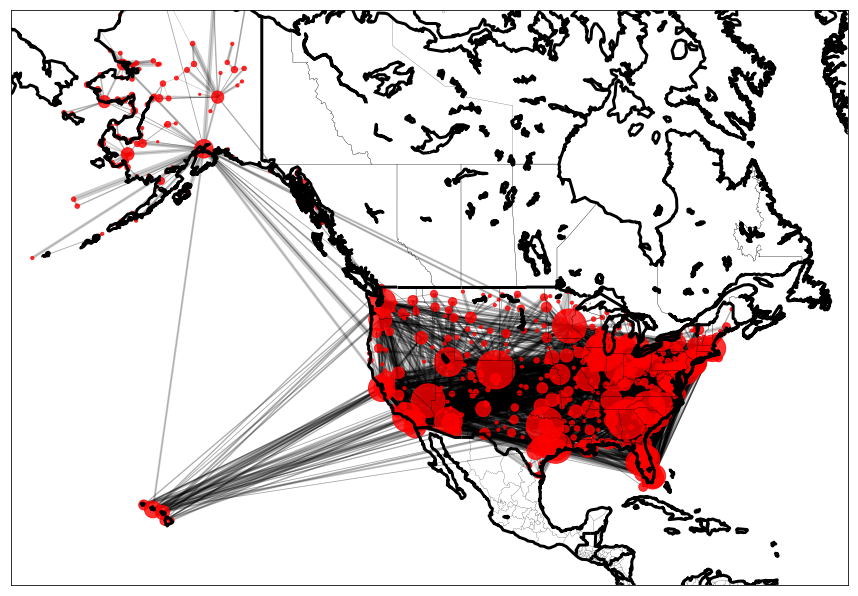

In [56]:
m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=3)
plt.show()

#### In-land airports

In [28]:
### get the airport
airport_us = airport_df[(airport_df.Country == "United States") & (airport_df.Lat > 25) & (airport_df.Lat < 50) &
                       (airport_df.Long > -130) & (airport_df.Long < -60)]

In [29]:
airport_us.shape

(1230, 13)

In [30]:
route_name = ['Airline', 'Airline ID', 'Source Airport', 'Source Airport ID',
              'Dest Airport', 'Dest Airport ID', 'Codeshare', 'Stops', 'equipment']
routes_df = pd.read_csv("https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat",
                        names = route_name)
us_airport_ix = airport_us.index.values
routes_df['Source Airport ID'] = routes_df['Source Airport ID'].astype(str)
routes_df['Dest Airport ID'] = routes_df['Dest Airport ID'].astype(str)
routes_df = routes_df[(routes_df['Source Airport ID'] != "\N") & (routes_df['Dest Airport ID'] != "\N") ]
routes_df['Source Airport ID'] = pd.to_numeric(routes_df['Source Airport ID'])
routes_df['Dest Airport ID'] = pd.to_numeric(routes_df['Dest Airport ID'])
routes_us = routes_df[(routes_df['Source Airport ID'].isin(us_airport_ix)) &
                     (routes_df['Dest Airport ID'].isin(us_airport_ix))]
routes_us =  pd.DataFrame(routes_us.groupby(['Source Airport', 'Dest Airport']).size().reset_index(name='counts'))
routes_us.sort_values(['counts'], ascending = False).head()

,Source Airport,Dest Airport,counts
3456,ORD,ATL,20
206,ATL,ORD,19
3545,ORD,MSY,13
192,ATL,MIA,12
3052,MIA,ATL,12


In [31]:
# to find number of flights in and out of an airport
# it is similar to find number of rows in which each airport occur in either one of the 2 columns

#You can use loc to filter out row level matches from 'col2', 
#append the filtered 'col2' values to 'col1',
#and then call value_counts

counts = routes_us['Source Airport'].append(routes_us.loc[routes_us['Source Airport'] != routes_us['Dest Airport'], 'Dest Airport']).value_counts()

In [32]:
counts.head()

ATL    301
ORD    289
DEN    283
DFW    270
MSP    230
dtype: int64

In [33]:
# create a data frame of position based on names in count
counts = pd.DataFrame({'IATA': counts.index, 'total_flight': counts})

In [34]:
pos_data = counts.merge(airport_us, on = 'IATA')

In [36]:
total_dic = pos_data[['IATA', 'total_flight']].set_index('IATA').T.to_dict('records')

In [38]:
graph = nx.from_pandas_dataframe(routes_us, source = 'Source Airport', target = 'Dest Airport',
                        edge_attr = 'counts',create_using = nx.MultiDiGraph())
nx.set_node_attributes(graph,total_dic[0], "total_ins_outs")

In [52]:
plt.figure(figsize=(15,20))
m = Basemap(
        projection='merc',
        llcrnrlon=-130,
        llcrnrlat=25,
        urcrnrlon=-60,
        urcrnrlat=50,
        lat_ts=0,
        resolution='l',
        suppress_ticks=True)

In [49]:
mx, my = m(pos_data['Long'].values, pos_data['Lat'].values)
pos = {}
for count, elem in enumerate (pos_data['IATA']):
    pos[elem] = (mx[count], my[count])

In [53]:
nx.draw_networkx_nodes(G = graph, pos = pos, node_list = graph.nodes(), node_color = 'r', alpha = 0.8,
                       node_size = [total_dic[0][s]*5 for s in graph.nodes()])
nx.draw_networkx_edges(G = graph, pos = pos, color='grey', width = routes_us['counts']*0.75, 
                       alpha=0.05, arrows = False)

D:\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3296: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
D:\Anaconda2\lib\site-packages\mpl_toolkits\basemap\__init__.py:3305: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


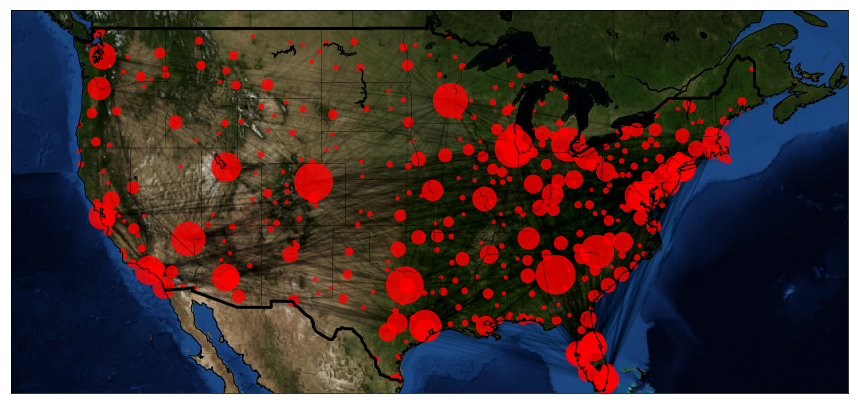

In [54]:
m.drawcountries(linewidth = 3)
m.drawstates(linewidth = 0.2)
m.drawcoastlines(linewidth=1)
m.bluemarble()
plt.show()